In [1]:
#Eureka ATM Laser Offsets
# (calculates the altitudinal offsets between flyovers over the Eureka 2016 fyi and myi sites)
# uses patches and averages the average of the altitudes of the laser data in the patches and uses,
# and compares these mean-of-means altitudes for each flyover to calculate the offset
#Claude de Rijke-Thomas
#16th May 2022
icetype = 'fyi'

In [2]:
from LPS_functions import *

In [3]:
#initialising empty arrays:
lat = np.array([], dtype='double')
lon = np.array([], dtype='double')
b_as = np.array([],dtype='int')
b_si = np.array([], dtype='int')
snow_depth_dot_n = np.array([], dtype='double')

insitu_data_filepath = '/Users/claudederijkethomas/Desktop/PhD/PYTHON/OIB/19-21Apr2016/SR/insitu_data_eureka.csv'

#opening the csv file to read through (to make a loading bar of progress):
line_count=0

with open(insitu_data_filepath, 'r') as csvfile:
    readCSV = csv.DictReader(csvfile)
    #establishing the headers as the first line of the file:
    headers = readCSV.fieldnames
    for line in readCSV:
        line_count+=1

        
#Timestamp,Counter,DepthCm,Latitude,Longitude,Site,IceType are the headers
Timestamp = np.array([], dtype='str')
Counter = np.array([], dtype='int')
DepthCm = np.array([], dtype='double')
Latitude = np.array([], dtype='double')
Longitude = np.array([], dtype='double')
Site = np.array([], dtype='str')
IceType = np.array([], dtype='str')

with open(insitu_data_filepath, 'r') as csvfile:
    readCSV = csv.DictReader(csvfile)
    #establishing the headers as the first line of the file:
    headers = readCSV.fieldnames
    count=-1
    for line in readCSV:
        count+=1
        if count%1000==0:
            sys.stdout.write("\r"+str(100*count/line_count)+"% of the way ")
        if str(line['Timestamp'][0:2]).isdigit():
            if int(line['Timestamp'][0:2])>=15: # if data is taken on the 15th or later
                if str(line['IceType'])==icetype:
                    Timestamp = np.append(Timestamp, str(line['Timestamp']))
                    Counter = np.append(Counter, int(line['Counter']))
                    DepthCm = np.append(DepthCm, float(line['DepthCm']))
                    Latitude = np.append(Latitude, float(line['Latitude']))
                    Longitude = np.append(Longitude, float(line['Longitude']))
                    Site = np.append(Site, str(line['Site']))
                    IceType = np.append(IceType, str(line['IceType']))

    sys.stdout.write("\r"+"100% complete                 ")

100% complete                  

In [4]:
if icetype=='fyi':
    coincident_ku_files = ['IRKUB1B_20160419_04_004_deconv.nc', 'IRKUB1B_20160419_04_032_deconv.nc', 'IRKUB1B_20160419_04_050_deconv.nc', 'IRKUB1B_20160419_04_080_deconv.nc',\
                           'IRKUB1B_20160419_04_180_deconv.nc', 'IRKUB1B_20160419_04_208_deconv.nc', 'IRKUB1B_20160419_04_230_deconv.nc', 'IRKUB1B_20160419_04_258_deconv.nc',\
                           'IRKUB1B_20160419_04_259_deconv.nc']
    
    ku_file = 'IRKUB1B_20160419_04_004_deconv.nc' #file that goes straight down the middle of the FYI in situ plot
elif icetype=='myi':
    coincident_ku_files = ['IRKUB1B_20160419_04_035_deconv.nc', 'IRKUB1B_20160419_04_047_deconv.nc', 'IRKUB1B_20160419_04_083_deconv.nc', 'IRKUB1B_20160419_04_176_deconv.nc',\
                           'IRKUB1B_20160419_04_211_deconv.nc', 'IRKUB1B_20160419_04_226_deconv.nc', 'IRKUB1B_20160419_04_262_deconv.nc']
    
    ku_file = 'IRKUB1B_20160419_04_226_deconv.nc' #file that goes straight down the middle of the MYI in situ plot

In [5]:
lon_ku, lat_ku, alt_ku, pitch_angle, roll_angle, aircraft_alt_ku, appropriate_indices = KuBandSurface(ku_file, threshold_fraction=0.7)
patch_size=100
LSxs,LSys = xysEveryLengthScale(lon_ku,lat_ku, patch_size, track_break_off_length=5000, coordtype='degrees')

"""finding the ATM laser data KDTree that corresponds to the each ku file for each flyover"""
coords_every_LS = np.column_stack((LSxs,LSys)) # xy coordinates every length scale

patch_atm_alts_means_tot = []
patch_atm_alts_stds_tot = []
patch_ku_alts_means_tot = []
patch_atm_rolls_means_tot = []
patch_atm_pitches_means_tot = []
#need to make sure that there's corresponding ATM data so use _filt:
for i, ku_file in enumerate(coincident_ku_files):

    #I need the corresponing atm file and the altitudes of the atm laser data:
    print(i+1)
    x_ku,y_ku,alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, appropriate_indices = correctEastNorthKu(ku_file, coord_sys="ease")

    h5_files = []
    for coinc in coincidence_arr:
        for sub_arr in coinc:
            if ku_file in sub_arr:
                #finding the kdtree that corresponds to the atm laser data file that coincides with ku_file:
                h5_files.append(coinc[0])
    h5_files = list(dict.fromkeys(h5_files))
    atm = projectedLaser(h5_files, "ease")
    x_atm,y_atm = atm.east, atm.north

    atmKDTree = spatial.cKDTree(np.column_stack((x_atm, y_atm)))
    kuKDTree = spatial.cKDTree(np.column_stack((x_ku, y_ku)))
    #empty 2D array for the ATM indices for the data corresponding to each patch:
    atm_LS_patches_indices_arr = []
    ku_LS_patches_indices_arr = []
    #looping over the centres of the patches that we'll calculate averages of:
    for coord in coords_every_LS:
        atm_neigh_list = []
        ku_neigh_list = []
        ku_neigh_list.append(kuKDTree.query_ball_point(coord,r=patch_size/2))
        atm_neigh_list.append(atmKDTree.query_ball_point(coord,r=patch_size/2))
        try:
            atm_neigh_indices = [atm_neigh_list[0][i] for i in range(len(atm_neigh_list[0]))]
        except:
            atm_neigh_indices = []
            raise
        try:
            ku_neigh_indices = [ku_neigh_list[0][i] for i in range(len(ku_neigh_list[0]))]
        except:
            ku_neigh_indicies = []
            raise
        atm_LS_patches_indices_arr.append(atm_neigh_indices)
        ku_LS_patches_indices_arr.append(ku_neigh_indices)

    patch_atm_alts_means = []
    patch_atm_alts_stds = []
    patch_atm_rolls_means = []
    patch_atm_pitches_means= []
    #'patch' represents a bunch of atm indices that correspond to one of the particular length-scale patches in question:
    for patch_indices in atm_LS_patches_indices_arr:
        patch_atm_alts_means.append(np.nanmean([atm.alt[patch_indices[j]] for j in range(len(patch_indices))]))
        patch_atm_alts_stds.append(np.nanstd([atm.alt[patch_indices[j]] for j in range(len(patch_indices))], ddof=1))
        patch_atm_rolls_means.append(np.nanmean([atm.roll[patch_indices[j]] for j in range(len(patch_indices))]))
        patch_atm_pitches_means.append(np.nanmean([atm.pitch[patch_indices[j]] for j in range(len(patch_indices))]))
    patch_ku_alts_means = []
    for patch_indices in ku_LS_patches_indices_arr:
        patch_ku_alts_means.append(np.nanmean([alt_ku[patch_indices[j]] for j in range(len(patch_indices))]))
    patch_atm_alts_means_tot.append(patch_atm_alts_means)
    patch_atm_alts_stds_tot.append(patch_atm_alts_stds)
    patch_atm_rolls_means_tot.append(patch_atm_rolls_means)
    patch_atm_pitches_means_tot.append(patch_atm_pitches_means)
    patch_ku_alts_means_tot.append(patch_ku_alts_means)

1
2
3
4
5
6
7
8
9


In [6]:
mean_atm_elev_each_flyover = np.mean(patch_atm_alts_means_tot,axis=1)
atm_elev_flyover_offsets = mean_atm_elev_each_flyover-np.mean(mean_atm_elev_each_flyover)

Text(0.5, 1.0, 'FYI')

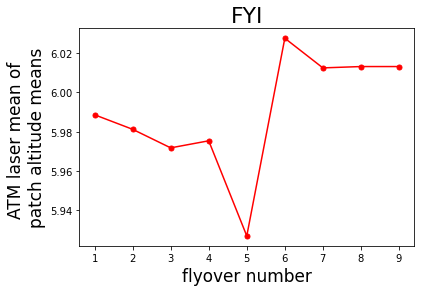

In [7]:
plt.plot(mean_atm_elev_each_flyover, 'r.-',markersize=10)
plt.xticks(range(len(mean_atm_elev_each_flyover)),labels =np.arange(1,len(mean_atm_elev_each_flyover)+1));
plt.ylabel("ATM laser mean of \npatch altitude means", fontsize=17)
plt.xlabel("flyover number", fontsize=17)
plt.title(icetype.upper(), fontsize=22)

In [8]:
#fyi : [-0.00142218, -0.00882589, -0.0182781,  -0.01468046, -0.06314833,  0.0375774, 0.02246962,  0.02315396,  0.02315396]
# myi : [-0.01541401, -0.02724434, -0.00367711, -0.05813091, 0.03078281,  0.03742214, 0.03626142]